# Forecasting Walmart's products prices

## Bartłomiej Adamiec

**Dlaczego te dane?**

Poszukiwałem datasetu, który będzie jak najbardziej komercyjny, abym mógł pokazać to w CV. Dataset o wyróżnia się na tle innych tym, że ma wpisane święta dla Stanów Zjednoczonych oraz dni, w których wydawane są kwoty pieniężne do spożytkowania na jedzenie dzięki programowi SNAP (czynniki egzogeniczne). Dataset wymaga prognozowania dla 30 490 równoległych szeregów czasowych zgrupowanych hierarchicznie Stany → Sklepy → Kategorie → Działy → Produkty.

**Cel:**

Celem analizy jest optymalizacja zarządzania zapasami w celu uniknięcia braków towarowych oraz nadmiernego magazynowania.


**Opis datasetu:**

Dane konkursowe (M5 Forecasting - Accuracy) z Kaggle. Zadaniem w konkursie było przewidzenie sprzedaży produktów w sieci sklepów Walmart na następne 28 dni. Dataset składa się z 5 plików csv przypominających relacyjną bazę danych w schemacie gwiazdy. Historia sprzedaży (`sales_train_validation.csv`) to główna tabela, a czas (`calendar.csv`) i cena (`sales_prices.csv`) to oddzielne tabele.

**Krótkie opisy plików:**

* `sell_prices.csv` - ceny produktów netto w USD
* `calendar.csv` - daty w różnej postaci oraz święta
* `sales_train_validation.csv` -  ile danego produktu sprzedało się w danym dniu. Dane w formacie szerokim. Dane obejmują zakres 1913 dni
* `sales_train_evaluation.csv` - identyczne do validation, tylko zawiera w sobie 28 następnych dni. Został dodany po zakończeniu konkursu.
* `sample_submission.csv` - przykład formatu w jakim uczestnicy powinni oddać zadanie

[Źródło](https://www.kaggle.com/competitions/m5-forecasting-accuracy/datam)

## Importing data

In [3]:
import pandas as pd
from pathlib import Path

from numpy.version import full_version

In [4]:
data_directory = Path("m5-forecasting-accuracy")

data = {}

for file_path in data_directory.glob("*.csv"):
    file_name = file_path.stem

    print(f"Loading file: {file_name}")

    data[file_name] = pd.read_csv(file_path)

Loading file: sell_prices
Loading file: sample_submission
Loading file: calendar
Loading file: sales_train_validation
Loading file: sales_train_evaluation


##### Sell prices

In [5]:
sell_prices = data['sell_prices']
sell_prices.head()
# sell_price is net price

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [6]:
print("Rows:", sell_prices.shape[0])
print("Stores:", sell_prices['store_id'].unique())
print("Sum of distinct items:", sell_prices['item_id'].nunique())
print(sell_prices.isna().any())

Rows: 6841121
Stores: ['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']
Sum of distinct items: 3049
store_id      False
item_id       False
wm_yr_wk      False
sell_price    False
dtype: bool


##### Calendar

In [7]:
# wday = 1 is saturday!!!
calendar = data['calendar']
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [8]:
print("Rows:", calendar.shape[0])
print("Columns:", calendar.columns,"\n")
print("Event types:", calendar['event_type_1'].unique())
# SNAP - Supplemental Nutrition Assistance Program, if in row for snap_ column value is 1 that means in this day people in exact state have received money for food
# CA - California
# TX - Texas
# WI - Wisconsin
print(calendar.isna().any())
# num_cols = ["wm_yr_wk", "wday", "month", "year"]

Rows: 1969
Columns: Index(['date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'd',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI'],
      dtype='object') 

Event types: [nan 'Sporting' 'Cultural' 'National' 'Religious']
date            False
wm_yr_wk        False
weekday         False
wday            False
month           False
year            False
d               False
event_name_1     True
event_type_1     True
event_name_2     True
event_type_2     True
snap_CA         False
snap_TX         False
snap_WI         False
dtype: bool


##### Validation

In [9]:
validation = data['sales_train_validation']
validation.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [10]:
# d_ is id for distinct day, value in column is quantity of product sold in this day
print("Rows:", validation.shape[0])
print(validation.isna().any())

Rows: 30490
id          False
item_id     False
dept_id     False
cat_id      False
store_id    False
            ...  
d_1909      False
d_1910      False
d_1911      False
d_1912      False
d_1913      False
Length: 1919, dtype: bool


##### Evaluation

In [11]:
evaluation = (data['sales_train_evaluation'])
evaluation.head()
# the same thing that is in validation but have 28 more days

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


#### Optimizing

In [12]:
def to_int_16(dataframe):
    for col in dataframe.columns:
        if "int" in str(dataframe[col].dtype):
            dataframe[col] = dataframe[col].astype("int16")

In [13]:
to_int_16(calendar)
to_int_16(validation)
to_int_16(sell_prices)

In [14]:
ca1_sell_prices = sell_prices[sell_prices["store_id"] == "CA_1"]
ca1_validation = validation[validation["store_id"] == "CA_1"]

In [15]:
ca1_validation_columns_d = []
for col in ca1_validation.columns:
    if col.startswith("d_"):
        ca1_validation_columns_d.append(col)

ca1_validation_long = pd.melt(ca1_validation, value_vars=ca1_validation_columns_d, id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"], var_name="d_id", value_name="quantity_sold")

In [16]:
ca1_validation_calendar = pd.merge(ca1_validation_long, calendar, how="inner", left_on="d_id", right_on="d")
ca1_validation_calendar.drop(columns=["d_id"], inplace=True)
ca1_validation_calendar.head()

,id,item_id,dept_id,cat_id,store_id,state_id,quantity_sold,date,wm_yr_wk,weekday,...,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29,11101,Saturday,...,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29,11101,Saturday,...,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29,11101,Saturday,...,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29,11101,Saturday,...,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29,11101,Saturday,...,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0


In [17]:
columns_to_drop = ["id", "store_id", "state_id", "weekday", "wday", "month", "year", "d", "snap_WI", "snap_TX"]
ca1_validation_calendar.drop(columns=columns_to_drop, inplace=True)
ca1_validation_calendar.head()

,item_id,dept_id,cat_id,quantity_sold,date,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA
0,HOBBIES_1_001,HOBBIES_1,HOBBIES,0,2011-01-29,11101,NaN,NaN,NaN,NaN,0
1,HOBBIES_1_002,HOBBIES_1,HOBBIES,0,2011-01-29,11101,NaN,NaN,NaN,NaN,0
2,HOBBIES_1_003,HOBBIES_1,HOBBIES,0,2011-01-29,11101,NaN,NaN,NaN,NaN,0
3,HOBBIES_1_004,HOBBIES_1,HOBBIES,0,2011-01-29,11101,NaN,NaN,NaN,NaN,0
4,HOBBIES_1_005,HOBBIES_1,HOBBIES,0,2011-01-29,11101,NaN,NaN,NaN,NaN,0


In [18]:
ca1_validation_calendar_sell_prices = pd.merge(ca1_validation_calendar, ca1_sell_prices, how="left", on=["wm_yr_wk", "item_id"])
ca1_validation_calendar_sell_prices.head()

,item_id,dept_id,cat_id,quantity_sold,date,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,store_id,sell_price
0,HOBBIES_1_001,HOBBIES_1,HOBBIES,0,2011-01-29,11101,NaN,NaN,NaN,NaN,0,NaN,NaN
1,HOBBIES_1_002,HOBBIES_1,HOBBIES,0,2011-01-29,11101,NaN,NaN,NaN,NaN,0,NaN,NaN
2,HOBBIES_1_003,HOBBIES_1,HOBBIES,0,2011-01-29,11101,NaN,NaN,NaN,NaN,0,NaN,NaN
3,HOBBIES_1_004,HOBBIES_1,HOBBIES,0,2011-01-29,11101,NaN,NaN,NaN,NaN,0,NaN,NaN
4,HOBBIES_1_005,HOBBIES_1,HOBBIES,0,2011-01-29,11101,NaN,NaN,NaN,NaN,0,NaN,NaN


In [19]:
ca1_validation_calendar_sell_prices["sell_price"].info() # Can't convert to int16 because of NaN
ca1_validation_calendar_sell_prices["date"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 5832737 entries, 0 to 5832736
Series name: sell_price
Non-Null Count    Dtype  
--------------    -----  
4702895 non-null  float64
dtypes: float64(1)
memory usage: 44.5 MB
<class 'pandas.core.series.Series'>
RangeIndex: 5832737 entries, 0 to 5832736
Series name: date
Non-Null Count    Dtype 
--------------    ----- 
5832737 non-null  object
dtypes: object(1)
memory usage: 44.5+ MB


In [20]:
print(round(ca1_validation_calendar_sell_prices.memory_usage().sum()/1024**2, 2), "MB")

478.38 MB


In [21]:
ca1_validation_calendar_sell_prices["date"] = pd.to_datetime(ca1_validation_calendar_sell_prices["date"])
ca1_validation_calendar_sell_prices.rename(columns={"date": "ds", "quantity_sold": "y"}, inplace=True)

In [22]:
foods = ca1_validation_calendar_sell_prices[ca1_validation_calendar_sell_prices["cat_id"] == "FOODS"]

foods = foods.groupby("ds").agg({
    "y": "sum",
    "event_name_1": "first",
    "event_name_2": "first",
    "event_type_1": "first",
    "event_type_2": "first",
    "snap_CA": "first"
}).reset_index()

foods["event_name_1"] = foods["event_name_1"].fillna("None")
foods["event_name_2"] = foods["event_name_2"].fillna("None")
foods["event_type_1"] = foods["event_type_1"].fillna("None")
foods["event_type_2"] = foods["event_type_2"].fillna("None")

print("Usage:", round(foods.memory_usage().sum()/1024**2, 2), "MB")
foods.head()

Usage: 0.08 MB


,ds,y,event_name_1,event_name_2,event_type_1,event_type_2,snap_CA
0,2011-01-29,3239,None,None,None,None,0
1,2011-01-30,3137,None,None,None,None,0
2,2011-01-31,2008,None,None,None,None,0
3,2011-02-01,2258,None,None,None,None,1
4,2011-02-02,2032,None,None,None,None,1


In [23]:
loose_processed = ca1_validation_calendar_sell_prices[ca1_validation_calendar_sell_prices["dept_id"] == "FOODS_1"]

loose_processed = loose_processed.groupby("ds").agg({
    "y": "sum",
    "event_name_1": "first",
    "event_name_2": "first",
    "event_type_1": "first",
    "event_type_2": "first",
    "snap_CA": "first"
}).reset_index()

loose_processed["event_name_1"] = loose_processed["event_name_1"].fillna("None")
loose_processed["event_name_2"] = loose_processed["event_name_2"].fillna("None")
loose_processed["event_type_1"] = loose_processed["event_type_1"].fillna("None")
loose_processed["event_type_2"] = loose_processed["event_type_2"].fillna("None")
loose_processed.head()

,ds,y,event_name_1,event_name_2,event_type_1,event_type_2,snap_CA
0,2011-01-29,297,None,None,None,None,0
1,2011-01-30,284,None,None,None,None,0
2,2011-01-31,214,None,None,None,None,0
3,2011-02-01,175,None,None,None,None,1
4,2011-02-02,182,None,None,None,None,1


In [24]:
dairy_refrigerated = ca1_validation_calendar_sell_prices[ca1_validation_calendar_sell_prices["dept_id"] == "FOODS_2"]

dairy_refrigerated = dairy_refrigerated.groupby("ds").agg({
    "y": "sum",
    "event_name_1": "first",
    "event_name_2": "first",
    "event_type_1": "first",
    "event_type_2": "first",
    "snap_CA": "first"
}).reset_index()

dairy_refrigerated["event_name_1"] = dairy_refrigerated["event_name_1"].fillna("None")
dairy_refrigerated["event_name_2"] = dairy_refrigerated["event_name_2"].fillna("None")
dairy_refrigerated["event_type_1"] = dairy_refrigerated["event_type_1"].fillna("None")
dairy_refrigerated["event_type_2"] = dairy_refrigerated["event_type_2"].fillna("None")
dairy_refrigerated.head()

,ds,y,event_name_1,event_name_2,event_type_1,event_type_2,snap_CA
0,2011-01-29,674,None,None,None,None,0
1,2011-01-30,655,None,None,None,None,0
2,2011-01-31,396,None,None,None,None,0
3,2011-02-01,476,None,None,None,None,1
4,2011-02-02,354,None,None,None,None,1


In [25]:
fresh = ca1_validation_calendar_sell_prices[ca1_validation_calendar_sell_prices["dept_id"] == "FOODS_3"]

fresh = fresh.groupby("ds").agg({
    "y": "sum",
    "event_name_1": "first",
    "event_name_2": "first",
    "event_type_1": "first",
    "event_type_2": "first",
    "snap_CA": "first"
}).reset_index()

fresh["event_name_1"] = fresh["event_name_1"].fillna("None")
fresh["event_name_2"] = fresh["event_name_2"].fillna("None")
fresh["event_type_1"] = fresh["event_type_1"].fillna("None")
fresh["event_type_2"] = fresh["event_type_2"].fillna("None")
fresh.head()

,ds,y,event_name_1,event_name_2,event_type_1,event_type_2,snap_CA
0,2011-01-29,2268,None,None,None,None,0
1,2011-01-30,2198,None,None,None,None,0
2,2011-01-31,1398,None,None,None,None,0
3,2011-02-01,1607,None,None,None,None,1
4,2011-02-02,1496,None,None,None,None,1


## EDA

### Moving Average

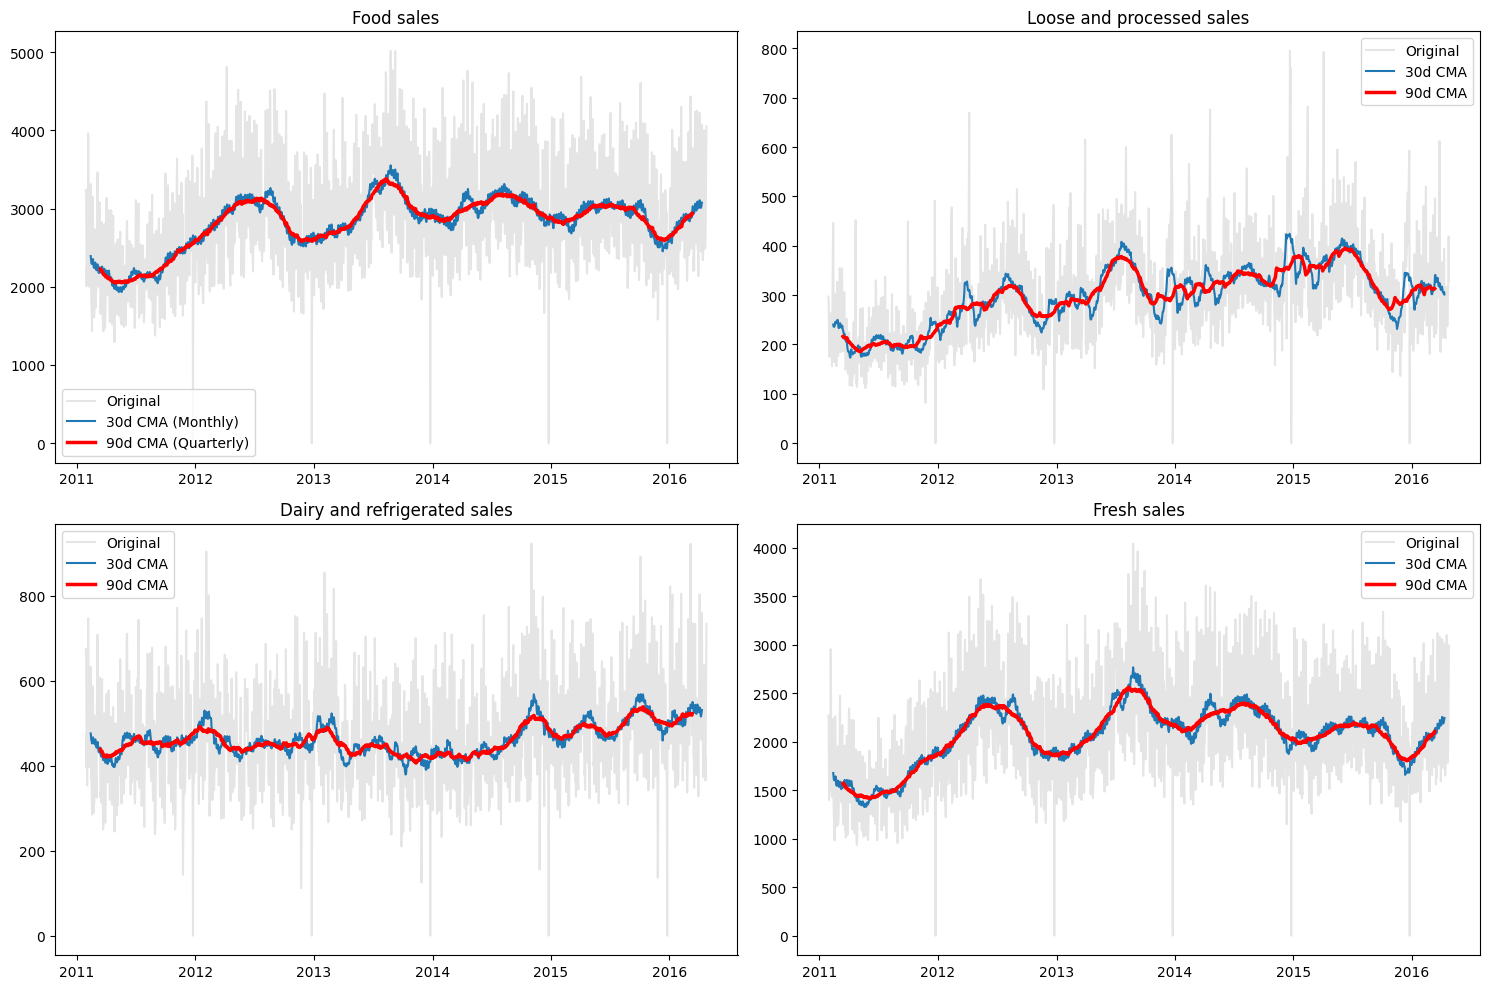

In [27]:
import matplotlib.pyplot as plt

foods_ma30 = foods['y'].rolling(window=30, center=True).mean()
loose_processed_ma30 = loose_processed['y'].rolling(window=30, center=True).mean()
dairy_refrigerated_ma30 = dairy_refrigerated['y'].rolling(window=30, center=True).mean()
fresh_ma30 = fresh['y'].rolling(window=30, center=True).mean()

foods_ma90 = foods['y'].rolling(window=90, center=True).mean()
loose_processed_ma90 = loose_processed['y'].rolling(window=90, center=True).mean()
dairy_refrigerated_ma90 = dairy_refrigerated['y'].rolling(window=90, center=True).mean()
fresh_ma90 = fresh['y'].rolling(window=90, center=True).mean()

fig, ((foods_plot, loose_processed_plot), (dairy_refrigerated_plot, fresh_plot)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

foods_plot.set_title('Food sales')
foods_plot.plot(foods['ds'], foods['y'], alpha=0.2, label='Original', color='gray')
foods_plot.plot(foods['ds'], foods_ma30, label='30d CMA (Monthly)', linewidth=1.5)
foods_plot.plot(foods['ds'], foods_ma90, label='90d CMA (Quarterly)', linewidth=2.5, color='red')
foods_plot.legend()

loose_processed_plot.set_title('Loose and processed sales')
loose_processed_plot.plot(loose_processed['ds'], loose_processed['y'], alpha=0.2, label='Original', color='gray')
loose_processed_plot.plot(loose_processed['ds'], loose_processed_ma30, label='30d CMA', linewidth=1.5)
loose_processed_plot.plot(loose_processed['ds'], loose_processed_ma90, label='90d CMA', linewidth=2.5, color='red')
loose_processed_plot.legend()

dairy_refrigerated_plot.set_title('Dairy and refrigerated sales')
dairy_refrigerated_plot.plot(dairy_refrigerated['ds'], dairy_refrigerated['y'], alpha=0.2, label='Original', color='gray')
dairy_refrigerated_plot.plot(dairy_refrigerated['ds'], dairy_refrigerated_ma30, label='30d CMA', linewidth=1.5)
dairy_refrigerated_plot.plot(dairy_refrigerated['ds'], dairy_refrigerated_ma90, label='90d CMA', linewidth=2.5, color='red')
dairy_refrigerated_plot.legend()

fresh_plot.set_title('Fresh sales')
fresh_plot.plot(fresh['ds'], fresh['y'], alpha=0.2, label='Original', color='gray')
fresh_plot.plot(fresh['ds'], fresh_ma30, label='30d CMA', linewidth=1.5)
fresh_plot.plot(fresh['ds'], fresh_ma90, label='90d CMA', linewidth=2.5, color='red')
fresh_plot.legend()

plt.tight_layout()
plt.show()

### Seasonality check

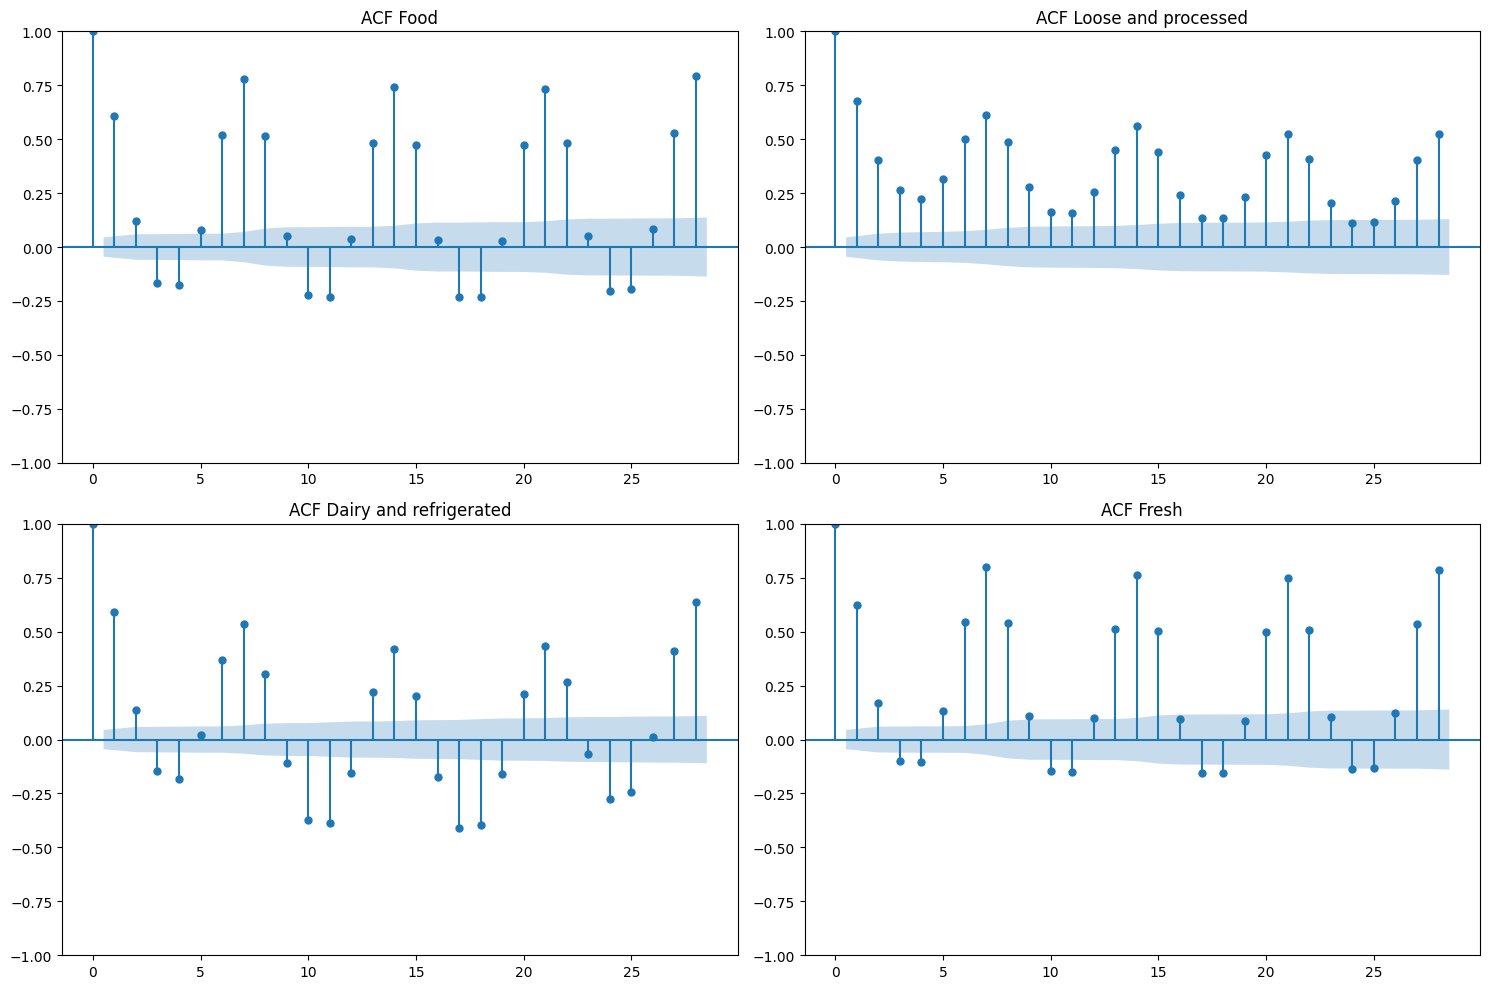

In [28]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
LAGS = 28
fig, ((foods_acf, loose_processed_acf), (dairy_refrigerated_acf, fresh_acf)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

plot_acf(foods['y'], lags=LAGS, ax=foods_acf)
foods_acf.set_title('ACF Food')

plot_acf(loose_processed['y'], lags=LAGS, ax=loose_processed_acf)
loose_processed_acf.set_title('ACF Loose and processed')

plot_acf(dairy_refrigerated['y'], lags=LAGS, ax=dairy_refrigerated_acf)
dairy_refrigerated_acf.set_title('ACF Dairy and refrigerated')

plot_acf(fresh['y'], lags=LAGS, ax=fresh_acf)
fresh_acf.set_title('ACF Fresh')

plt.tight_layout()
plt.show()

Evident weekly seasonality in each case. Interesting that loose and processed products have only positive correlation. Possible slight trend damping in loose and processed.

### Stationarity

In [29]:
# stacjonarność
# dickey fuler

### Exponential Smoothing

In [30]:
# exp smoothong